In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
import time
import math
import sys
import random
from ast import literal_eval

from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

%matplotlib inline

# Data Initialization

In [2]:
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups", "total"]

train_path = '/Users/YINAN/Local/Sea-lions/Data/Train/'
train_dotted_path = '/Users/YINAN/Local/Sea-lions/Data/TrainDotted/'

bad_images = [3,7,9,21,30,34,71,81,89,97,151,184,215,234,242,268,290,311,331,344,380,384,406,421,469,475,490,499,507,
              530,531,605,607,614,621,638,644,687,712,721]

file_names = [str(x) + '.jpg' for x in range(0,750) if x not in bad_images]
coordinates_df = pd.DataFrame(index=file_names, columns=classes)
# read all the coordinates 
coordinates_df = pd.read_csv("./coordinates.csv", index_col='index', converters={"total": literal_eval})

In [3]:
coordinates_df.shape

(710, 6)

In [5]:
def sliding_window(image):
    patches = []
    for row in range(image.shape[0]//96):
        for col in range(image.shape[1]//96):
            patch_rgb = cv2.cvtColor(image[row*96:row*96+96, col*96:col*96+96], cv2.COLOR_BGR2RGB)
            patches.append(patch_rgb)
    return patches

def extract_patches_with_sealions(coordinates_df, num_patches):
    patches = []
    coordinates_df = coordinates_df.sample(frac=1)
    for filename in coordinates_df.index:
        image = cv2.imread(train_path + filename)
        for coordinates in coordinates_df.loc[filename].total:
            thumb = image[coordinates[1]-48:coordinates[1]+48,coordinates[0]-48:coordinates[0]+48,:]
            if np.shape(thumb) == (96, 96, 3):
                patches.append(cv2.cvtColor(thumb, cv2.COLOR_BGR2RGB))
                print("\r%d patches completes, with total %d"%(len(patches), num_patches), end='')
                sys.stdout.flush()
                if len(patches) == num_patches:
                    return patches
                  
def extract_patches_without_sealions(coordinates_df, num_patches):
    patches = []
    coordinates_df = coordinates_df.sample(frac=1)
    for filename in coordinates_df.index:
        sealion_coordinates_list = coordinates_df.loc[filename].total
        image = cv2.imread(train_path + filename)
        for row in range(image.shape[0]//96):
            for col in range(image.shape[1]//96):
                center = (row*96+48, col*96+48)
                flag = True
                for thumb in sealion_coordinates_list:
                    if math.sqrt((center[0] - thumb[1])**2 + (center[1] - thumb[0])**2) < math.sqrt(2)*96:
                        flag = False
                        break
                if flag:
                    patch_rgb = cv2.cvtColor(image[row*96:row*96+96, col*96:col*96+96], cv2.COLOR_BGR2RGB)
                    patches.append(patch_rgb)
                    print("\r%d patches completes, with total %d"%(len(patches), num_patches), end='')
                    sys.stdout.flush()
                    if len(patches) == num_patches:
                        return patches

def get_features(patch):
    features = {}
    features["R"] = np.average(patch[:,:,0])
    features["G"] = np.average(patch[:,:,1])
    features["B"] = np.average(patch[:,:,2])
    features['Blue_max'] = np.max(patch[:,:,2])
    return features

def construct_dataset(coordinate_df, pos_num, neg_num, feature_names):
    
    pos_df = pd.DataFrame(columns=feature_names)
    print("constructing pos data...")
    patches = extract_patches_with_sealions(coordinates_df, pos_num)
    print("\nstart extracting patches...")
    for i in range(len(patches)):
        patch = patches[i]
        pos_df = pos_df.append(get_features(patch), ignore_index=True)
        print("\r%d patch completes, with total %d"%(i, len(patches)), end='')
    pos_df['class'] = 1
    
    neg_df = pd.DataFrame(columns=feature_names)
    print("\nconstructing neg data...")
    patches = extract_patches_without_sealions(coordinates_df, neg_num)
    print("\nstart extracting patches...")
    for i in range(len(patches)):
        patch = patches[i]
        neg_df = neg_df.append(get_features(patch), ignore_index=True)
        print("\r%d patch completes, with total %d"%(i, len(patches)), end='')
    neg_df['class'] = 0
    
    total = pos_df.append(neg_df)
    print("\n"+"-"*20)
    print("Data construction completes.\npos={}, neg={}".format(len(pos_df), len(neg_df)))
    return total

def train_classifier(data, reg, threshold, random_state):
    target = 'class'
    variables = data.columns[data.columns != target]
    x_train, x_test,y_train, y_test = \
    model_selection.train_test_split(data[variables], data[target], test_size = 0.33)
    logistic = linear_model.LogisticRegression(C=reg, random_state=random_state)
    logistic.fit(x_train, y_train)
    y_pred = prediction_with_threshold(logistic, threshold, x_test)

    print("recall score is {}".format(recall_score(y_test, y_pred)))
    print("precision score is {}".format(precision_score(y_test, y_pred)))
    return logistic
    
def ClassifyWithThreshold(probabilities, threshold):
    return [+1 if x>=threshold else 0 for x in probabilities]

def prediction_with_threshold(classifier, threshold, x_test):
    return ClassifyWithThreshold(classifier.predict_proba(x_test)[:,1], threshold)
    
def classify_patch(patch, classifier, threshold):
    features = get_features(patch)
    df = pd.DataFrame.from_dict([features])
    pred = prediction_with_threshold(classifier, threshold, df[["R","G","B", "Blue_max"]])
    return 1 if pred[0] == 1 else 0

# Pipeline

* positive patches extraction
* negative patches extraction
* train a simple logistic regression binary classifier
* testing

In [6]:
train = construct_dataset(coordinate_df=coordinates_df, pos_num=50000, neg_num=50000, feature_names=["R","G","B", "Blue_max"])

constructing pos data...
50000 patches completes, with total 50000
start extracting patches...
49999 patch completes, with total 50000
constructing neg data...
50000 patches completes, with total 50000
start extracting patches...
49999 patch completes, with total 50000
--------------------
Data construction completes.
pos=50000, neg=50000


In [7]:
baseline = len(train[train['class'] == 1])/len(train)
print("precision baseline is %f"%baseline)

precision baseline is 0.500000


In [8]:
logistic_classifier = train_classifier(data=train, reg=1e-5,threshold=0.2,random_state=1)

recall score is 0.9542040222922219
precision score is 0.6325596337643563


# Test the module with a new data set

In [9]:
test = construct_dataset(coordinate_df=coordinates_df, pos_num=1000, neg_num=10000, feature_names=["R","G","B", "Blue_max"])

constructing pos data...
1000 patches completes, with total 1000
start extracting patches...
999 patch completes, with total 1000
constructing neg data...
10000 patches completes, with total 10000
start extracting patches...
9999 patch completes, with total 10000
--------------------
Data construction completes.
pos=1000, neg=10000


In [10]:
baseline = len(test[test['class'] == 1])/len(test)
print("baseline is %f"%baseline)

baseline is 0.090909


In [11]:
target = 'class'
variables = test.columns[test.columns != target]
y = test[target]
y_pred = prediction_with_threshold(classifier=logistic_classifier, threshold=0.2, x_test=test[variables])
print("recall score is {}".format(recall_score(y, y_pred)))
print("precision score is {}".format(precision_score(y, y_pred)))

recall score is 0.98
precision score is 0.12417638114546375


In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=y, y_score=y_pred)

0.64439999999999997

# Real situation testing

When a new image arrives, we need to first use sliding window to extract all the patches without overlapping. Then using the logistic regresion classifier to classify the patches.

In [14]:
test_image = cv2.imread(train_path + '57.jpg')
patches = sliding_window(test_image)

In [15]:
pos = []
neg = []
for patch in patches:
    p = classify_patch(patch, logistic_classifier, 0.2)
    if p == 1:
        pos.append(patch)
    else:
        neg.append(patch)

In [16]:
print("Total patches number is %d\npos number is %d, neg number is %d"%(len(patches), len(pos), len(neg)))

Total patches number is 1768
pos number is 1503, neg number is 265


pos examples


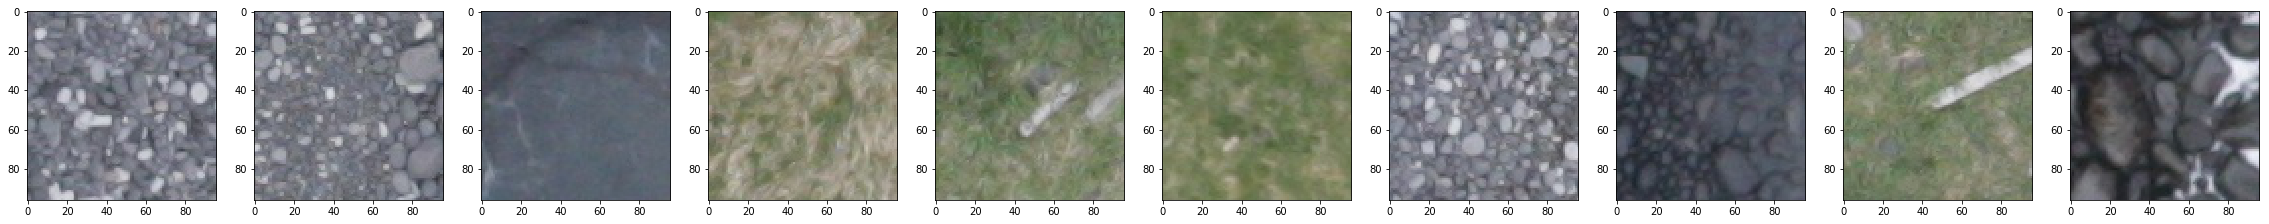

In [34]:
f, ax = plt.subplots(1,10, figsize=(40,10))
random_index = np.random.choice(len(pos), 10, replace=True)
for index, a in enumerate(ax):
    a.imshow(pos[random_index[index]])
print("pos examples")

neg examples


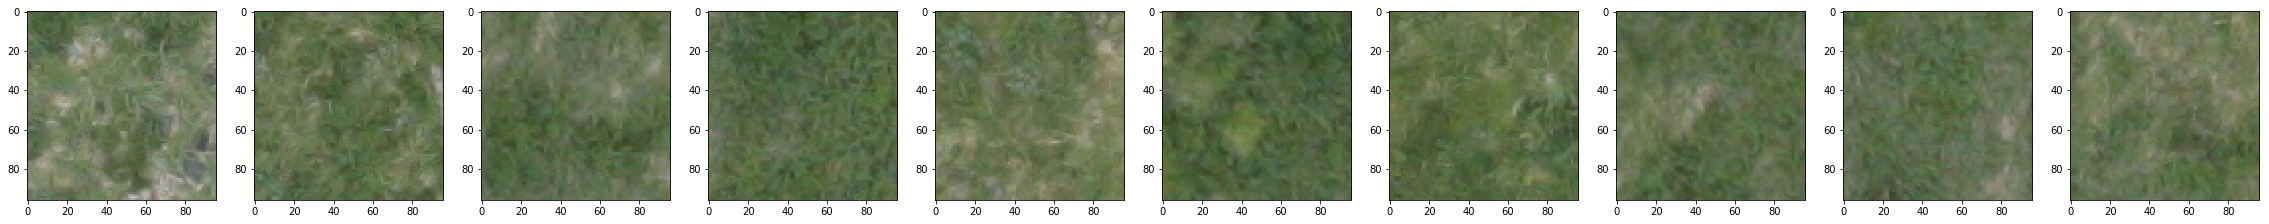

In [31]:
f, ax = plt.subplots(1,10, figsize=(40,10))
random_index = np.random.choice(len(neg), 10, replace=True)
for index, a in enumerate(ax):
    a.imshow(neg[random_index[index]])
print("neg examples")